This file is to price snowball by monte carlo simulation method and binomial tree method with forward shooting grid function.
The basic assumption about the snowball:
$$Notiontal amount(N):100\_000\_000,\ \ stock\ volatility(\sigma): 0.16,$$
$$risk\ free intetrest(r)=3\%,\ \ securities\ borrowing(q):9.5\%$$
$$knock-out\ coupon\ rate(kc)=16\%, \ \ coupon\ rate(c)=16\%$$
$$invest\ horizon/time(T):24(months),\ \ locked\ time(Tl)=3(months) $$
$$stepdown(s)=0.5\%,\ \ stepdown\ begin\ time(Ts)=4 $$
$$original\ knock-out\ barrier:100\%,\ \ knock-in\ barrier=75\%$$

For computing simplicity, I assume all intervals of knock-out day are the 1 month with 30/360 daily counting convention and
The interval can be divide into one day if necessary.


In [ ]:
#I thought my pricing model is right, but the given parameters are not typical,
#thus the snowball value priced is negative, which is not reasonable

# Also, I have some questions when I calcualte and plot the greeks 
#I am not sure about which variables are to control, so I'm worried it as well

#Besides, I used FSG method to price it, however my time interval is not small enough, the result is not accurate.

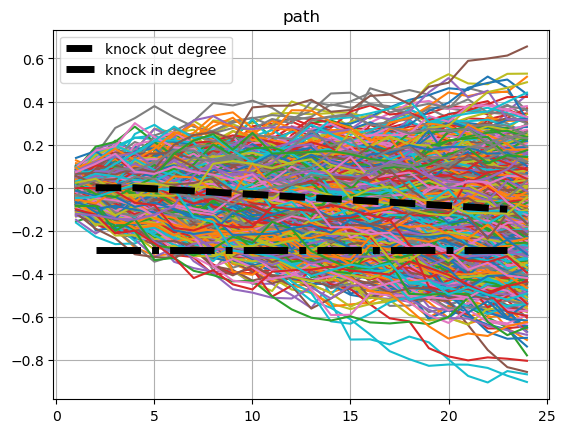

In [22]:
#monte carlo method 
import numpy as np
import matplotlib.pyplot as plt
#we denote the price level with log(S) to avoid time-costing logarithm comuptation\
#in monte carlo process
r=0.03;q=0.095;sigma=0.16;dt=1/12;T=2;N=100_000_000
knock_in=0.75;n=1000000
#We use argmax to postion the index of knock/in event, if we only use 22 data, we cannot
#distinguish whether the first observation month encounter knock/in or knock/in no event happens in
#the full trail. First two observation months dont exist,so we set them to 100, 
#as impossible to knock out, so if knock/in event happens in the third observation month, argmax
#will return index 2; return 0 if no knock/in event happens.
knock_out_degree_array=np.array([*([100]*2),*([0]*22)],dtype=float)
knock_out_degree_array[-20:]=np.log(np.linspace(1,0.905,20))
path=np.random.randn(n,24)*sigma*np.sqrt(dt)+(r-q-0.5*sigma**2)*dt
path=path.cumsum(axis=1)

plt.plot(range(1,25),path[:min(1000,path.shape[0]),:].T)
plt.plot(range(2,24),knock_out_degree_array[-22:],'k--',label='knock out degree',linewidth=5)
plt.plot(range(2,24),np.log(knock_in)*np.ones(22),'k-.',label='knock in degree',linewidth=5)
plt.legend()
plt.grid()
plt.title('path')
plt.show()

the trails that knockout happens:			 0.752113 
averate payoff:	 0.06342880058458206
the trails that knockin happens and no knockout happen:	 0.213234 
averate payoff:	 -0.32247978322500825
the trails that no knockout and knockout happens:	 0.034653 
averate payoff:	 0.30136465074695973
pricing of snowball by monte carlo simulation:		 -661035.5891051586


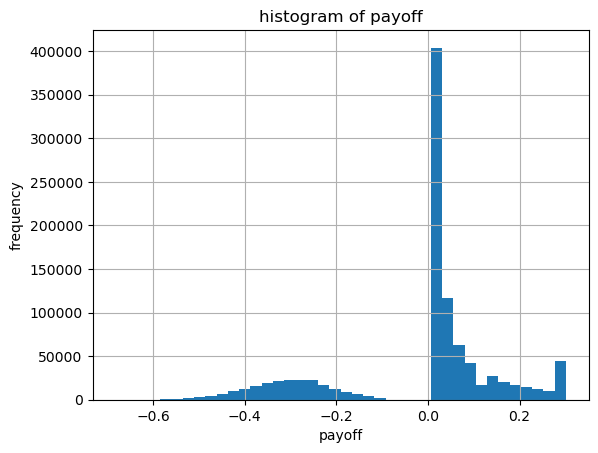

In [2]:
arg_knockout=np.argmax(path[:,]>knock_out_degree_array,axis=1)
arg_knockin=np.argmax(path[:,]<np.log(knock_in),axis=1)
arg_knockout_indicatior=arg_knockout>=2
arg_knockin_no_knockout_indicatior=(arg_knockout<2)*(arg_knockin>=2)
arg_no_knockin_no_knockout_indicatior=(arg_knockout<2)*(arg_knockin<2)
#knockout and no knockin
value_out=(np.exp(-r*arg_knockout[arg_knockout_indicatior]*dt)*arg_knockout[arg_knockout_indicatior]*dt*0.16)
#no knockout and no knockin
value_noin_noout=arg_no_knockin_no_knockout_indicatior[arg_no_knockin_no_knockout_indicatior!=0]*2*0.16*np.exp(-r*2)
#knock in and no knockout, similar to a put option 
array_in_noout=np.exp(path[arg_knockin_no_knockout_indicatior,-1])-1
value_in_noout=np.where(array_in_noout>0,0,array_in_noout)*np.exp(-r*2)
print("the trails that knockout happens:\t\t\t",arg_knockout_indicatior.sum()/n,"\naverate payoff:\t", value_out.mean())
print("the trails that knockin happens and no knockout happen:\t",arg_knockin_no_knockout_indicatior.sum()/n,"\naverate payoff:\t", array_in_noout.mean())
print("the trails that no knockin and knockout happens:\t",arg_no_knockin_no_knockout_indicatior.sum()/n,"\naverate payoff:\t", value_noin_noout.mean())
print("pricing of snowball by monte carlo simulation:\t\t",(value_out.sum()+value_noin_noout.sum()+value_in_noout.sum())/n*N)
result=np.concatenate((value_out,value_noin_noout,value_in_noout),axis=0)
plt.hist(result,bins=40)
plt.xlabel('payoff')
plt.ylabel('frequency')
plt.grid()
plt.title('histogram of payoff')
plt.show()

In [4]:
def snowball_pricing(r=0.03,t=0,sigma=0.16,St=1):
    q=0.095;dt=1/12;T=2;knock_in=0.75;n=500000
    step=int((T-t*dt)/dt)
    knock_out_degree_array=np.array([*([100]*2),*([0]*22)],dtype=float)
    knock_out_degree_array[-20:]=np.log(np.linspace(1,0.905,20))
    path=St*np.random.randn(n,step)*sigma*np.sqrt(dt)+(r-q-0.5*sigma**2)*dt
    path=path.cumsum(axis=1)
    arg_knockout=np.argmax(path[:,]>(knock_out_degree_array[-step:]),axis=1)
    arg_knockin=np.argmax(path[:,]<np.log(knock_in),axis=1)
    arg_knockout_indicatior=arg_knockout>=2
    arg_knockin_no_knockout_indicatior=(arg_knockout<2)*(arg_knockin>=2)
    arg_no_knockin_no_knockout_indicatior=(arg_knockout<2)*(arg_knockin<2)
    #knockout and no knockin
    value_out=(np.exp(-r*arg_knockout[arg_knockout_indicatior]*dt)*arg_knockout[arg_knockout_indicatior]*dt*0.16)
    #no knockout and no knockin
    value_noin_noout=arg_no_knockin_no_knockout_indicatior[arg_no_knockin_no_knockout_indicatior!=0]*2*0.16*np.exp(-r*(2-t*dt))
    #knock in and no knockout, similar to a put option 
    array_in_noout=np.exp(path[arg_knockin_no_knockout_indicatior,-1])-1
    value_in_noout=np.where(array_in_noout>0,0,array_in_noout)*np.exp(-r*(2-t*dt))
    return (value_out.sum()+value_noin_noout.sum()+value_in_noout.sum())/n


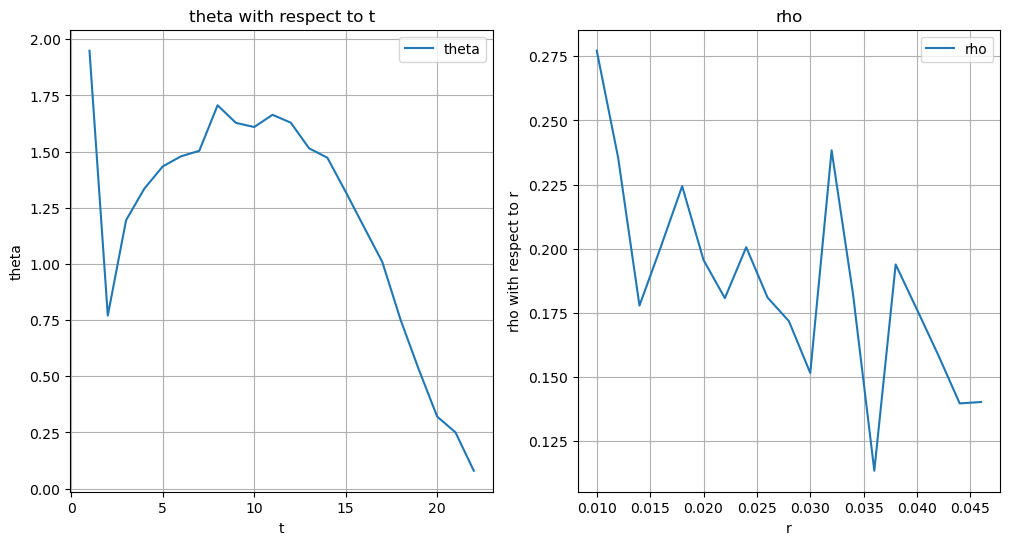

In [13]:
from itertools import product
from joblib import Parallel, delayed
t_list=list(range(1,24))
sample_t_tilst=[0,5,10,15,20]
sigma_list=np.arange(0.1,0.31,0.01)
St_list=np.arange(0.2,3,0.1)
r_list=np.arange(0.01,0.05,0.002)

value_with_t=Parallel(n_jobs=16)(delayed(snowball_pricing)(t=i) for i in t_list)
value_with_r=Parallel(n_jobs=16)(delayed(snowball_pricing)(r=i) for i in r_list)
rho=np.diff(value_with_r)/0.01
theta=np.diff(value_with_t)/0.01
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].plot(t_list[:-1],theta,label='theta')
ax[0].set_xlabel('t')
ax[0].set_ylabel('theta')
ax[0].set_title('theta with respect to t')
ax[0].legend()
ax[0].grid()
ax[1].plot(r_list[:-1],rho,label='rho')
ax[1].set_xlabel('r')
ax[1].set_ylabel('rho with respect to r')
ax[1].set_title('rho')
ax[1].legend()
ax[1].grid()
plt.show()

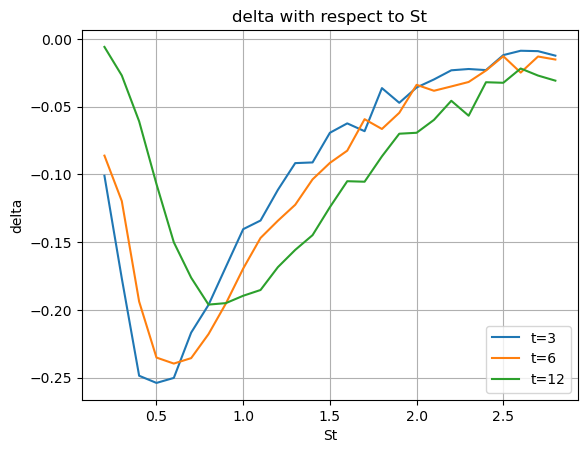

In [14]:
plt.plot(St_list[:-1],np.diff(Parallel(n_jobs=16)(delayed(snowball_pricing)(St=i,t=3) for i in St_list))/0.1,label='t=3')
plt.plot(St_list[:-1],np.diff(Parallel(n_jobs=16)(delayed(snowball_pricing)(St=i,t=6) for i in St_list))/0.1,label='t=6')
plt.plot(St_list[:-1],np.diff(Parallel(n_jobs=16)(delayed(snowball_pricing)(St=i,t=12) for i in St_list))/0.1,label='t=12')
plt.xlabel('St')
plt.ylabel('delta')
plt.title('delta with respect to St')
plt.legend()
plt.grid()
plt.show()

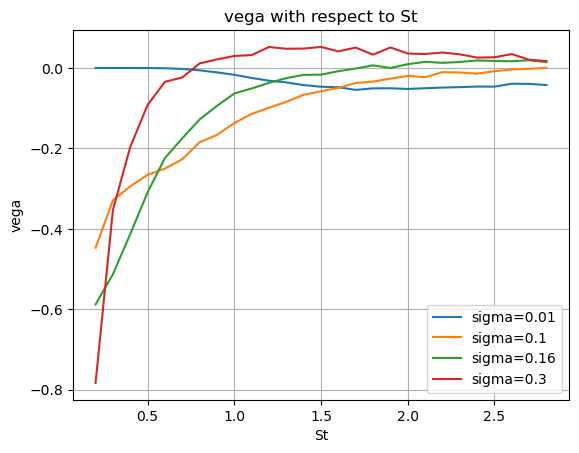

In [15]:
plt.plot(St_list[:-1],np.diff(Parallel(n_jobs=16)(delayed(snowball_pricing)(St=i,sigma=0.01) for i in St_list))/0.1,label='sigma=0.01')
plt.plot(St_list[:-1],np.diff(Parallel(n_jobs=16)(delayed(snowball_pricing)(St=i,sigma=0.1) for i in St_list))/0.1,label='sigma=0.1')
plt.plot(St_list[:-1],np.diff(Parallel(n_jobs=16)(delayed(snowball_pricing)(St=i,sigma=0.16) for i in St_list))/0.1,label='sigma=0.16')
plt.plot(St_list[:-1],np.diff(Parallel(n_jobs=16)(delayed(snowball_pricing)(St=i,sigma=0.3) for i in St_list))/0.1,label='sigma=0.3')
plt.xlabel('St')
plt.ylabel('vega')
plt.title('vega with respect to St')
plt.legend()
plt.grid()
plt.show()
#vega大多数时候为负

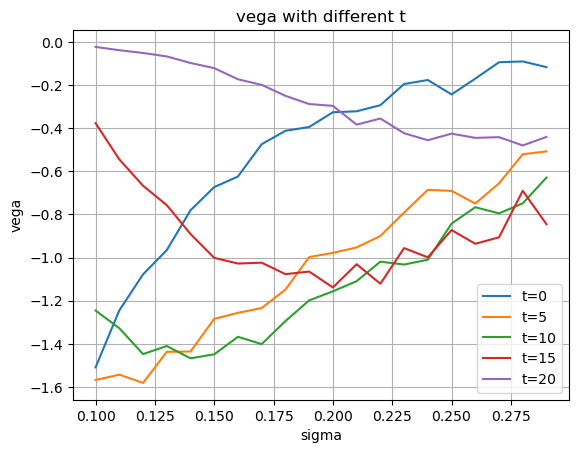

In [18]:
cal_vega_t=lambda sigma_list,t:np.diff( [snowball_pricing(sigma=sigma,t=t) for sigma in sigma_list])/0.01
vega_with_t=Parallel(n_jobs=16)(delayed(cal_vega_t)(sigma_list=sigma_list,t=ti) for ti in sample_t_tilst) 
for i,vega in enumerate(vega_with_t):
    plt.plot(sigma_list[:-1],vega,label='t={}'.format(sample_t_tilst[i]))
plt.legend()
plt.xlabel('sigma')
plt.ylabel('vega')
plt.title('vega with different t')
plt.grid()
plt.show()
#t=0时，波动率低的话不出意外很容易knockin,波动率高的话有一定概率knockout，所以上坡曲线是可以理解的
#过一段时间，t=5，股票价格水平没变，这时候低波动率不容易knockin（得益于前面若干时间股票价格水平没有变化）；
#随着波动率增高，knockin的风险增加，vega有一个谷值；随着波动率继续增高，knockout的几率也在增加
#随着时间的推移，vega会变小，因为趋近于到期日，更可能拿到票息，到了后期股票自身的价格仍维持在1，
#这意味着股票大概率会knockout，除非波动率大到一定程度，以至于价格下跌至knockin而蒙受损失
#注意：本例中的knockout水平低于期初水平，在后续时间意味着并不存在股票价格保持不变（S=1）的情况，
#早已knockout，但我们此处跳过这些情况，只考虑波动率的影响

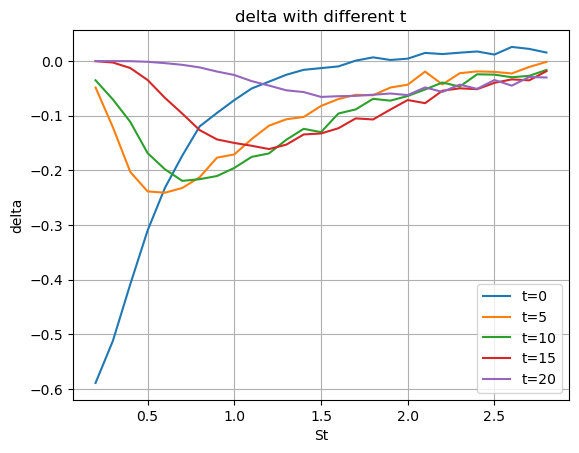

In [19]:
cal_delta_t=lambda St_list,t:np.diff( [snowball_pricing(St=St,t=t) for St in St_list])/0.1
delta_with_t=Parallel(n_jobs=16)(delayed(cal_delta_t)(St_list=St_list,t=ti) for ti in sample_t_tilst)

for i,delta in enumerate(delta_with_t):
    plt.plot(St_list[:-1],delta,label='t={}'.format(sample_t_tilst[i]))
    plt.legend()
    plt.xlabel('St')
    plt.ylabel('delta')
    plt.title('delta with different t')
    plt.grid()
plt.show()
#收到模拟次数的影响，以及简单的显式差分法的影响，只能大致看出随着时间增大，delta会变小的规律
#隐式差分法或者CN差分法可以更好地解决这个问题

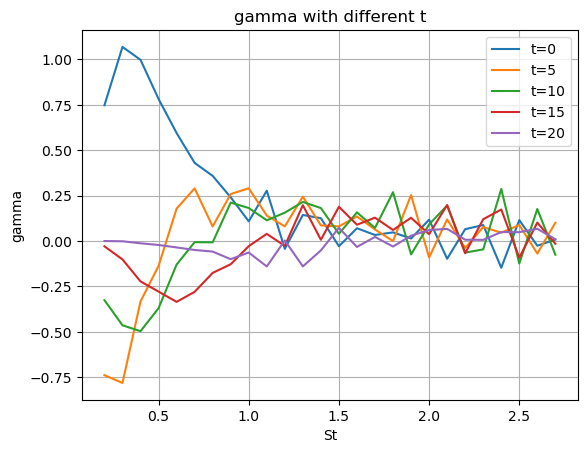

In [20]:
cal_gamma_t=lambda St_list,t:np.diff(np.diff( [snowball_pricing(St=St,t=t) for St in St_list],1),1)/0.1**2
gamma_with_t=Parallel(n_jobs=16)(delayed(cal_gamma_t)(St_list=St_list,t=ti) for ti in sample_t_tilst)
for i,gamma in enumerate(gamma_with_t):
    plt.plot(St_list[:-2],gamma,label='t={}'.format(sample_t_tilst[i]))
    plt.legend()
    plt.xlabel('St')
    plt.ylabel('gamma')
    plt.title('gamma with different t')
    plt.grid()
plt.show()
#gamma的稳定性很差

In [1]:
#pricing by binomial tree with forward shooting grid method
#this is a correct method to price, but the result is not accurate, because the grid is not dense enough(time interval is too large)
import numpy as np

r=0.03;q=0.095;sigma=0.16;dt=1/12;T=2;N=100_000_000
knock_in=0.75;n=100000;c=0.16
u=np.exp(sigma*np.sqrt(dt))
d=1/u
p=(np.exp((r-q)*dt)-d)/(u-d)
panel=np.full((25,25*2),np.nan)
#panel=np.zeros((25,25*2))
#in term i, there are i+1 nodes for stock(j times u and i-j times d),
#and two nodes for whether knock/in(k=1 denotes knockin event happened),
#we present the situaition with k*(i+1)+j, get the terminal payoff and backward calculate
knock_out_degree_array=np.array([*[1]*2,*np.linspace(1,0.905,20)],dtype=float)
for i in reversed(range(25)):
    for j in range(i+1):
        S=u**(j)*d**(i-j)
        if i==2:
            if S*d<knock_in and S>knock_in:
                panel[i,j]=np.exp(-r*dt)*(p*panel[i+1,j+1]+(1-p)*panel[i+1,1*(i+2)+j])
            elif S*d<knock_in and S<knock_in:
                panel[i,j]=np.exp(-r*dt)*(p*panel[i+1,1*(i+2)+j+1]+(1-p)*panel[i+1,1*(i+2)+j])
            else: panel[i,j]=np.exp(-r*dt)*(p*panel[i+1,j+1]+(1-p)*panel[i+1,j])
        elif i<2:
            panel[i,j]=np.exp(-r*dt)*(p*panel[i+1,j+1]+(1-p)*panel[i+1,j])
        else:
            for k in range(2):
                if i==24:
                    panel[i,k*(i+1)+j]=(S>knock_out_degree_array[i-3])*i*dt*c+\
                        (S<knock_out_degree_array[i-3])*(k==0)*i*dt*c+\
                            (S<knock_out_degree_array[i-3])*(k==1)*min(S-1,0)
                elif i>2:
                    if S>=knock_out_degree_array[i-3]:
                        panel[i,k*(i+1)+j]=dt*i*c
                    else:
                        if k==1:
                            panel[i,k*(i+1)+j]=np.exp(-r*dt)*(p*panel[i+1,k*(i+2)+j+1]+(1-p)*panel[i+1,k*(i+2)+j])
                        if k==0:
                            if S*d<knock_in:
                                panel[i,k*(i+1)+j]=np.exp(-r*dt)*(p*panel[i+1,k*(i+2)+j+1]+(1-p)*panel[i+1,1*(i+2)+j])
                            else:
                                panel[i,k*(i+1)+j]=np.exp(-r*dt)*(p*panel[i+1,k*(i+2)+j+1]+(1-p)*panel[i+1,k*(i+2)+j])
print(panel[0,0]*N)

577754.9731932806


In [1]:
#上述雪球期权的设定或许有些奇怪，因为q过高导致股票价格一直下行，greek和我们设想的不太一样且产品定价为负数。所以我们可以换一组参数进行定价
import numpy as np

def snowball_pricing(r=0.03,t=0,sigma=0.13,St=1):
    r=0.03;t=0;sigma=0.13;St=1
    q=0;dt=1/12;T=1;knock_in=0.85;knock_out=1.03;n=1000000
    step=int((T-t*dt)/dt)
    knock_out_degree=np.log([1000,*([knock_out]*step)])
    knock_in_degree=np.log([0.001,*([knock_in]*step)])
    path=St*np.random.randn(n,step)*sigma*np.sqrt(dt)+(r-q-0.5*sigma**2)*dt
    path=path.cumsum(axis=1)
    path=np.hstack((np.ones((n,1)),path))

    arg_knockout=np.argmax(path[:,]>knock_out_degree,axis=1)
    arg_knockin=np.argmax(path[:,]<knock_in_degree,axis=1)
    arg_knockout_indicatior=arg_knockout>=1
    arg_knockin_no_knockout_indicatior=(arg_knockout<1)*(arg_knockin>=1)
    arg_no_knockin_no_knockout_indicatior=(arg_knockout<1)*(arg_knockin<1)
    #knockout and no knockin
    value_out=(np.exp(-r*arg_knockout[arg_knockout_indicatior]*dt)*arg_knockout[arg_knockout_indicatior]*dt*0.16)
    #no knockout and no knockin
    value_noin_noout=arg_no_knockin_no_knockout_indicatior[arg_no_knockin_no_knockout_indicatior!=0]*T*0.16*np.exp(-r*2)
    #knock in and no knockout, similar to a put option 
    array_in_noout=np.exp(path[arg_knockin_no_knockout_indicatior,-1])-1
    value_in_noout=np.where(array_in_noout>0,0,array_in_noout)*np.exp(-r*T)
    return (value_out.sum()+value_noin_noout.sum()+value_in_noout.sum())/n

snowball_pricing()

0.04217961028737749

In [52]:
r=0.03;t=0;sigma=0.13;St=1
q=0;dt=1/12;T=1;knock_in=0.85;knock_out=1.03;n=1000000
step=int((T-t*dt)/dt)
knock_out_degree=np.log([1000,*([knock_out]*step)])
knock_in_degree=np.log([0.001,*([knock_in]*step)])
path=St*np.random.randn(n,step)*sigma*np.sqrt(dt)+(r-q-0.5*sigma**2)*dt
path=path.cumsum(axis=1)
path=np.hstack((np.ones((n,1)),path))

arg_knockout=np.argmax(path[:,]>knock_out_degree,axis=1)
arg_knockin=np.argmax(path[:,]<knock_in_degree,axis=1)
arg_knockout_indicatior=arg_knockout>=1
arg_knockin_no_knockout_indicatior=(arg_knockout<1)*(arg_knockin>=1)
arg_no_knockin_no_knockout_indicatior=(arg_knockout<1)*(arg_knockin<1)
#knockout and no knockin
value_out=(np.exp(-r*arg_knockout[arg_knockout_indicatior]*dt)*arg_knockout[arg_knockout_indicatior]*dt*0.16)
#no knockout and no knockin
value_noin_noout=arg_no_knockin_no_knockout_indicatior[arg_no_knockin_no_knockout_indicatior!=0]*T*0.16*np.exp(-r*2)
#knock in and no knockout, similar to a put option 
array_in_noout=np.exp(path[arg_knockin_no_knockout_indicatior,-1])-1
value_in_noout=np.where(array_in_noout>0,0,array_in_noout)*np.exp(-r*T)
print("the trails that knockout happens:\t\t\t",arg_knockout_indicatior.sum()/n,"\naverate payoff:\t", value_out.mean())
print("the trails that knockin happens and no knockout happen:\t",arg_knockin_no_knockout_indicatior.sum()/n,"\naverate payoff:\t", array_in_noout.mean())
print("the trails that no knockin and knockout happens:\t",arg_no_knockin_no_knockout_indicatior.sum()/n,"\naverate payoff:\t", value_noin_noout.mean())
print("pricing of snowball by monte carlo simulation:\t\t",(value_out.sum()+value_noin_noout.sum()+value_in_noout.sum())/n)

the trails that knockout happens:			 0.736887 
averate payoff:	 0.04614481354701849
the trails that knockin happens and no knockout happen:	 0.102397 
averate payoff:	 -0.16121918459447274
the trails that no knockin and knockout happens:	 0.160716 
averate payoff:	 0.1506823253734799
pricing of snowball by monte carlo simulation:		 0.04218798164809223
